# Livrable 2 : Classification

|Auteur|Centre|Modification|
|---|---|---|
|Emilien Pons|Toulouse|2021/01/15|
|Nicolas Hurtevent|Toulouse|2021/01/15|
|Pierre Mazurier|Toulouse|2021/01/15|
|Pacome Chu-Lejeune|Toulouse|2021/01/15|

![logoEI_1_6.jpg](https://arras.cesi.fr/wp-content/uploads/sites/9/2019/05/Cesi_Logo_INGENIEUR_RVB-HD-500x296.jpg)

## Introduction

L'entreprise TouNum, travaillant sur la numérisation de documents, nous demande de réaliser une solution d'image captioning. L'architecture de la solution est composée de plusieurs modules, comme décrit sur le schéma suivant.

[SCHEMA]

L'architecture de la solution d'image-captionning est composée de 4 modules : un module de chargement d'image, un module déterminant si l'image est une photo ou non, un troisième module de traitement basique d'image pour la rendre plus éxploitable et un dernier module de captionning.

L'entreprise souhaite automatiser la sélection de photos pour l'annotations. Nous allons donc, dans ce document, **détailler notre méthode permettant de filtrer si une image est une photo ou non**. Cette approche utilise des réseaux de neuronnes, nous allons comparer plusieurs modèles entrainés sur les mêmes données et les comparer.

Ce modèle sera utilisé par la suite sur la solution de captionning finale.

# PLAN

- Mise en place de TensorFlow
- Fonctions utilisées
    - Initialisation du notebook
    - Préparation des datasets
- Création des modèles
    - Petite intro pour parler des CNN et comme quoi modèle simple ne font pas l'affaire
    - Modèle Baseline
        - 1. Le modèle (avec schéma)
        - 2. Analyse des résultats
    - Modèle DNN
        - 1. Le modèle (avec schéma)
        - 2. Les paramètres
        - 3. La fonction de perte 
        - 4. Algorithmme d'optimisation pour l'entrainement
     - Analyse des résultats DNN
        - 1. Graphique analyse erreur entrainement
        - 2. Erreur de test
        - 3. Evolution de l'accuracy pour ces deux datasets
    - Modèle CNN 1
        - 1. Le modèle (avec schéma)
        - 2. Les paramètres
        - 3. La fonction de perte 
        - 4. Algorithmme d'optimisation pour l'entrainement
     - Analyse des résultats CNN 1
        - 1. Graphique analyse erreur entrainement
        - 2. Erreur de test
        - 3. Evolution de l'accuracy pour ces deux datasets
    - Compromis analyse de l'over/under feating
        - 1. Qu'est ce que c'est ?
        - 2. Interprétation de notre résultat
    - Comment améliorer nos résultats
    - Modèle CNN 2 (version améliorée)
        - 1. Le modèle (avec schéma)
        - 2. Les paramètres
        - 3. La fonction de perte 
        - 4. Algorithmme d'optimisation pour l'entrainement
     - Analyse des résultats CNN 2
        - 1. Graphique analyse erreur entrainement
        - 2. Erreur de test
        - 3. Evolution de l'accuracy pour ces deux datasets
     - Conclusion

## Mise en place de TensorFlow

Dans ce livrable, nous utilisons TensorFlow. C'est un outil d'apprentissage automatique développé par Google et l'un des outils les plus utilisés en IA dans le domaine du Machine Learning. Il nous offre une bibliothèque riche qui nous permettra de créer éfficacement des réseaux de neuronnes de toute architecture. C'est également l'outil que nous avons pu prendre en main lors de nos précèdents workshops.

![logo_TS](https://www.tensorflow.org/images/tf_logo_social.png)

**NB :** Si vous ne disposez pas encore de TensorFlow, l'instalation de la bibliothèque sous votre machine est la commande suivante. Vous pouvez aussi tenter de l'installer depuis la console Anaconda en suivant la [documentation](https://docs.anaconda.com/anaconda/user-guide/tasks/tensorflow/) officielle.

In [1]:
# pip install tensorflow

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os, os.path
import pathlib

In [3]:
img_height = 128
img_width = 128
batch_size = 32

image_h = img_height
image_w = img_width
batch_s = batch_size

In [4]:
data_dir = "dataset/testphoto"
data_dir = pathlib.Path(data_dir)

#load images and split train and test sets
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=  0.2,
  subset = 'training',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=  0.2,
  subset = 'validation',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)

Found 25952 files belonging to 2 classes.
Using 20762 files for training.
Found 25952 files belonging to 2 classes.
Using 5190 files for validation.


In [5]:
class_names =  train_set.class_names #a compl
print(class_names)
print(train_set)

['notphoto', 'photo']
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>


In [6]:
# #show exemple of an image
# images, labels = next(iter(test_set.take(1)))
# plt.imshow(images[0].numpy().astype("uint8"))

In [7]:
# print(images[0].shape)

In [8]:
# images, labels = next(iter(test_set.take(1)))
# plt.imshow(images[0].numpy().astype("uint8"))

In [9]:
# print(test_set)

In [10]:
# print(train_set)

In [11]:
# print(images.shape)
# print(labels.shape)

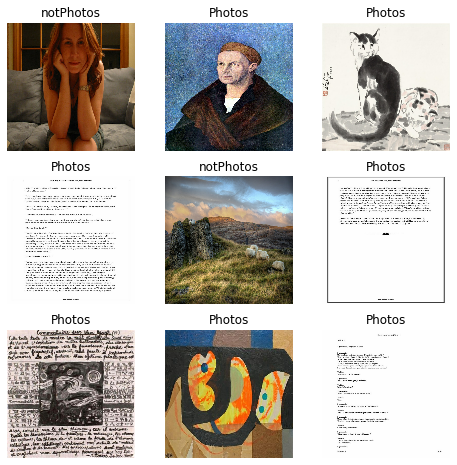

In [12]:
class_names = ['Photos', 'notPhotos']

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8")) #a compl
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
# #shuffle the train set
# #add caching and prefeching optimisations
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(100000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# train_set = train_set.shuffle(100000).prefetch(buffer_size=AUTOTUNE)
# test_set = test_set.prefetch(buffer_size=AUTOTUNE)

# train_set = train_set.shuffle(100000)
# test_set = test_set

In [14]:
# for image_batch, labels_batch in train_set :
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     break

In [15]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000000

# # train_set = (
# #     train_set
# #     .shuffle(BUFFER_SIZE)
# #     .batch(BATCH_SIZE, drop_remainder=True)
# #     .prefetch(tf.data.experimental.AUTOTUNE))
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_set = train_set.shuffle(100000).prefetch(buffer_size=AUTOTUNE)
# # test_set = test_set.prefetch(buffer_size=AUTOTUNE)

# train_set

In [16]:
# for image_batch, labels_batch in train_set :
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     break

# Generator

## Modèle

In [17]:
#retourne tt le temps que non
from sklearn.base import BaseEstimator
class AlwaysPhotoClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.ones((len(X),1), dtype=bool)
    
model_naive = AlwaysPhotoClassifier()

In [18]:
model = models.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(
    1./255, input_shape=(img_height, img_width, 3) #a compl
    )
)
# Couche convolutive
model.add(
    layers.Conv2D(16, 3, padding='same', activation='relu')#A COMPLETER
)
# Couche de pooling
model.add(
    layers.MaxPooling2D()#A COMPLETER
)
# Bloc convolutif ou la taille du filtre est de (32, 3)
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())#A COMPLETER

# Bloc convolutif ou la taille du filtre est de (64, 3)
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())#A COMPLETER

# Applatissement de la couche
model.add(layers.Flatten())#A COMPLETER

# Couche entièrement connectée (couche dense)
model.add(layers.Dense(128, activation='relu'))
#A COMPLETER

# Couche entièrement connectée retournant le résultat de la classification
model.add(layers.Dense(2))#A COMPLETER

In [19]:
model.compile(optimizer =  'adam', #A COMPLETER
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #A COMPLETER
              # loss = tf.keras.losses.SparseCategoricalCrossentropy(), #A COMPLETER
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0

In [20]:
epochs=10
history =  model.fit_generator(
    generator = train_set,
    validation_data=test_set,
    epochs=epochs
)

Epoch 1/10


C:\Users\Nico\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


649/649 [==============================] - 734s 646ms/step - loss: 0.4269 - accuracy: 0.7823 - val_loss: 0.2621 - val_accuracy: 0.8869
Epoch 2/10
649/649 [==============================] - 366s 564ms/step - loss: 0.2612 - accuracy: 0.8829 - val_loss: 0.2417 - val_accuracy: 0.8973
Epoch 3/10
649/649 [==============================] - 336s 517ms/step - loss: 0.1912 - accuracy: 0.9194 - val_loss: 0.2164 - val_accuracy: 0.9106
Epoch 4/10
649/649 [==============================] - 278s 428ms/step - loss: 0.1373 - accuracy: 0.9435 - val_loss: 0.1817 - val_accuracy: 0.9247
Epoch 5/10
649/649 [==============================] - 271s 418ms/step - loss: 0.0886 - accuracy: 0.9669 - val_loss: 0.1817 - val_accuracy: 0.9335
Epoch 6/10
649/649 [==============================] - 265s 409ms/step - loss: 0.0534 - accuracy: 0.9824 - val_loss: 0.2163 - val_accuracy: 0.9407
Epoch 7/10
649/649 [==============================] - 279s 431ms/step - loss: 0.0298 - accuracy: 0.9909 - val_loss: 0.2293 - val_accura

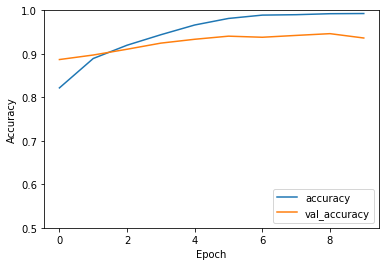

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [22]:
#try full dense nn pour comparer

In [23]:
model_dense = tf.keras.Sequential([
#     layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Flatten(input_shape=(img_height, img_width,3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [24]:
model_dense.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 6,292,874
Trainable params: 6,292,874
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_dense.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history =  model_dense.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/10
649/649 [==============================] - 22s 34ms/step - loss: 1915.4532 - accuracy: 0.6348 - val_loss: 824.3217 - val_accuracy: 0.6647
Epoch 2/10
649/649 [==============================] - 21s 33ms/step - loss: 414.8250 - accuracy: 0.7049 - val_loss: 1439.2058 - val_accuracy: 0.6568
Epoch 3/10
649/649 [==============================] - 21s 33ms/step - loss: 332.0490 - accuracy: 0.7227 - val_loss: 101.1527 - val_accuracy: 0.7609
Epoch 4/10
649/649 [==============================] - 21s 33ms/step - loss: 147.7276 - accuracy: 0.7481 - val_loss: 128.7448 - val_accuracy: 0.7306
Epoch 5/10
649/649 [==============================] - 21s 32ms/step - loss: 134.5414 - accuracy: 0.7507 - val_loss: 102.1647 - val_accuracy: 0.7050
Epoch 6/10
649/649 [==============================] - 23s 35ms/step - loss: 49.6332 - accuracy: 0.7878 - val_loss: 22.8952 - val_accuracy: 0.7663
Epoch 7/10
649/649 [==============================] - 22s 33ms/step - loss: 31.3739 - accuracy: 0.7737 - val_los

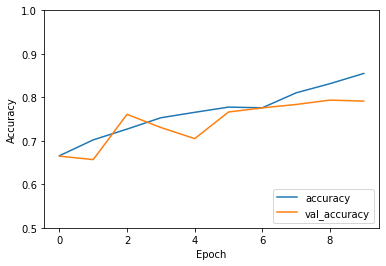

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_,  test_labels, verbose=2)

In [27]:
model_cnn_1 = models.Sequential()
#norma 
model_cnn_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model_cnn_1.add(layers.MaxPooling2D((2, 2)))
model_cnn_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn_1.add(layers.MaxPooling2D((2, 2)))
model_cnn_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn_1.add(layers.Flatten())
model_cnn_1.add(layers.Dense(64, activation='relu'))
model_cnn_1.add(layers.Dense(10))

In [28]:
model_cnn_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [29]:
model_cnn_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model_cnn_1.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

NameError: name 'train_images' is not defined

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_cnn_1.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

In [ ]:
#on peut faire un tableau comparatif des modèles

In [ ]:
#pas hésiter a ref les papier qui montrenet que tel modèle marche le mieux (et coup de bol c'est le notre)

In [ ]:
#grille d'éval : 1 implé (bon params et explication adaptée),2 description de l'archi et visualisation des résultats : dessin de l'archi,graph de compa pour chaque modèle et commentaire. on a sans rien, aved dropout et avec data augment. 3 conclue : points forts et faibles et piste d'amélio (style transfer learning)

In [ ]:
# on a un clssif binaire donc on a 1 neurone en output et on mesure l'accuracy avec metrics=tf.metrics.BinaryAccuracy(threshold=0.0))